In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
import matplotlib.pyplot as plt
from pathlib import Path
from tesse_gym.tasks.goseek.goseek_full_perception import GoSeekFullPerception, decode_observations
from envs.utils import make_unity_env
# from perception.tsdf_tools import TSDF 
import open3d as o3d
import numpy as np
import os
import tqdm
from common.tools import convert_pose_stack
test_data_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/tests/data2/'

In [3]:
n_train_envs = 2
episode_length = 50
filename = Path("/home/jd/competition/goseek-challenge/simulator/goseek-v0.1.4.x86_64")
assert filename.exists(), f"Must set a valid path!"

In [4]:
from tesse_gym import get_network_config
from tesse_gym.core.utils import set_all_camera_params
env = GoSeekFullPerception(
                str(filename),
                network_config=get_network_config(worker_id=0),
                n_targets=20,
                episode_length=50,
                scene_id=1,
                step_rate=20,
                init_hook=set_all_camera_params
            )

In [5]:
from tesse.msgs import *
from tesse.env import Env
import time
import defusedxml.ElementTree as ET

In [6]:
comm = Env()
_ = comm.request(SetCameraParametersRequest(Camera.DEPTH, 240, 320, 60, .05, 50))

In [21]:
env.reset()

array([0.21176471, 0.20392157, 0.19607843, ..., 0.        , 0.        ,
       0.        ])

In [53]:
_ = comm.request(SetCameraPositionRequest(Camera.DEPTH, 0, 0, 0))
_ = comm.request(SetCameraPositionRequest(Camera.RGB_LEFT, 0, 0, 0))
_ = comm.request(SetCameraPositionRequest(Camera.SEGMENTATION, 0, 0, 0))

In [42]:
response = comm.request(CameraInformationRequest())
if response is not None:
    print(response.metadata)

<TESSE_Agent_CameraInfo_v0.5>
  <camera_info>
    <name>rgb_left</name>
    <id>0</id>
    <parameters height='240' width='320' fov='60'/>
    <position x='-0.05' y='0' z='0'/>
    <rotation x='0' y='0' z='0' w='1'/>
    <draw_distance near='0.05' far='50'/>
  </camera_info>
  <camera_info>
    <name>rgb_right</name>
    <id>1</id>
    <parameters height='240' width='320' fov='60'/>
    <position x='0.05' y='0' z='0'/>
    <rotation x='0' y='0' z='0' w='1'/>
    <draw_distance near='0.05' far='50'/>
  </camera_info>
  <camera_info>
    <name>segmentation</name>
    <id>2</id>
    <parameters height='240' width='320' fov='60'/>
    <position x='-0.05' y='0' z='0'/>
    <rotation x='0' y='0' z='0' w='1'/>
    <draw_distance near='0.05' far='50'/>
  </camera_info>
  <camera_info>
    <name>depth</name>
    <id>3</id>
    <parameters height='240' width='320' fov='60'/>
    <position x='-0.05' y='0' z='0'/>
    <rotation x='0' y='0' z='0' w='1'/>
    <draw_distance near='0.05' far='50'/>
  

In [12]:
segmentation

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

<IPython.core.display.Javascript object>


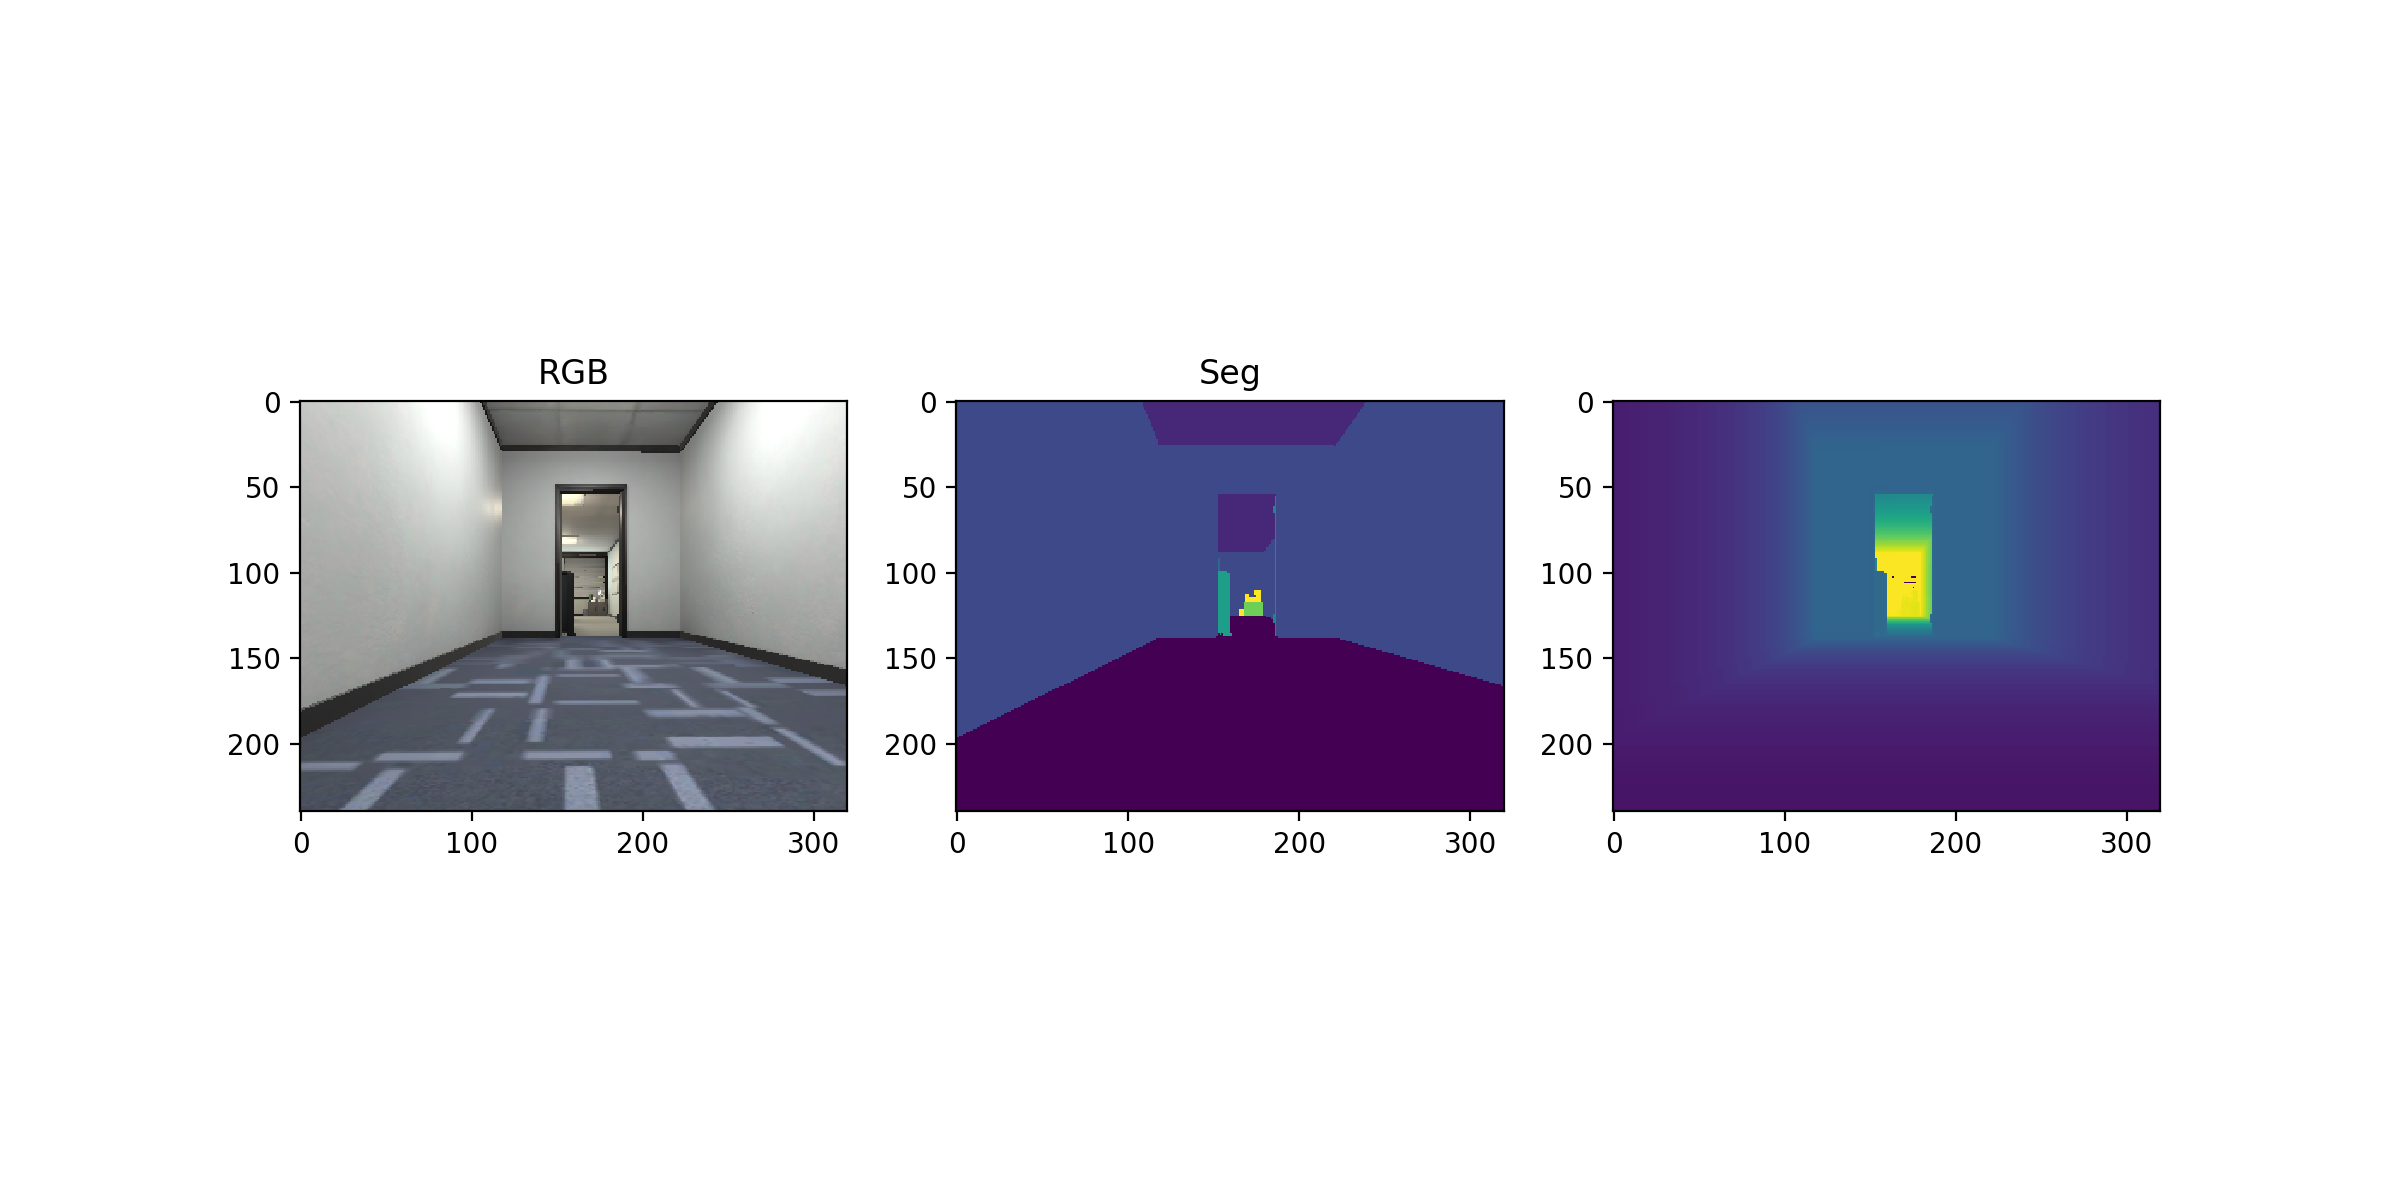

In [14]:
ob = env.form_agent_observation(env.observe())
rgb, segmentation, depth, pose = decode_ob(ob)
fig, ax = plt.subplots(1,3, figsize=(12, 6))
ax[0].set_title('RGB')
ax[1].set_title('Seg')
ax[0].imshow(rgb)
ax[1].imshow(segmentation)
ax[2].imshow(depth)

In [18]:
segmentation

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [30]:
ob = env.observe()
env._update_pose(ob.metadata)
env.get_pose()

array([0.        , 0.        , 0.52359887])

In [31]:
env.close()

In [8]:
def decode_ob(obs):
    img_shape = (240, 320, 5)
    imgs = obs[:-3].reshape(img_shape)
    rgb = imgs[..., :3]
    segmentation = imgs[..., 3]
    depth = imgs[..., 4]

    pose = obs[-3:]
    return rgb, segmentation, depth, pose

<IPython.core.display.Javascript object>


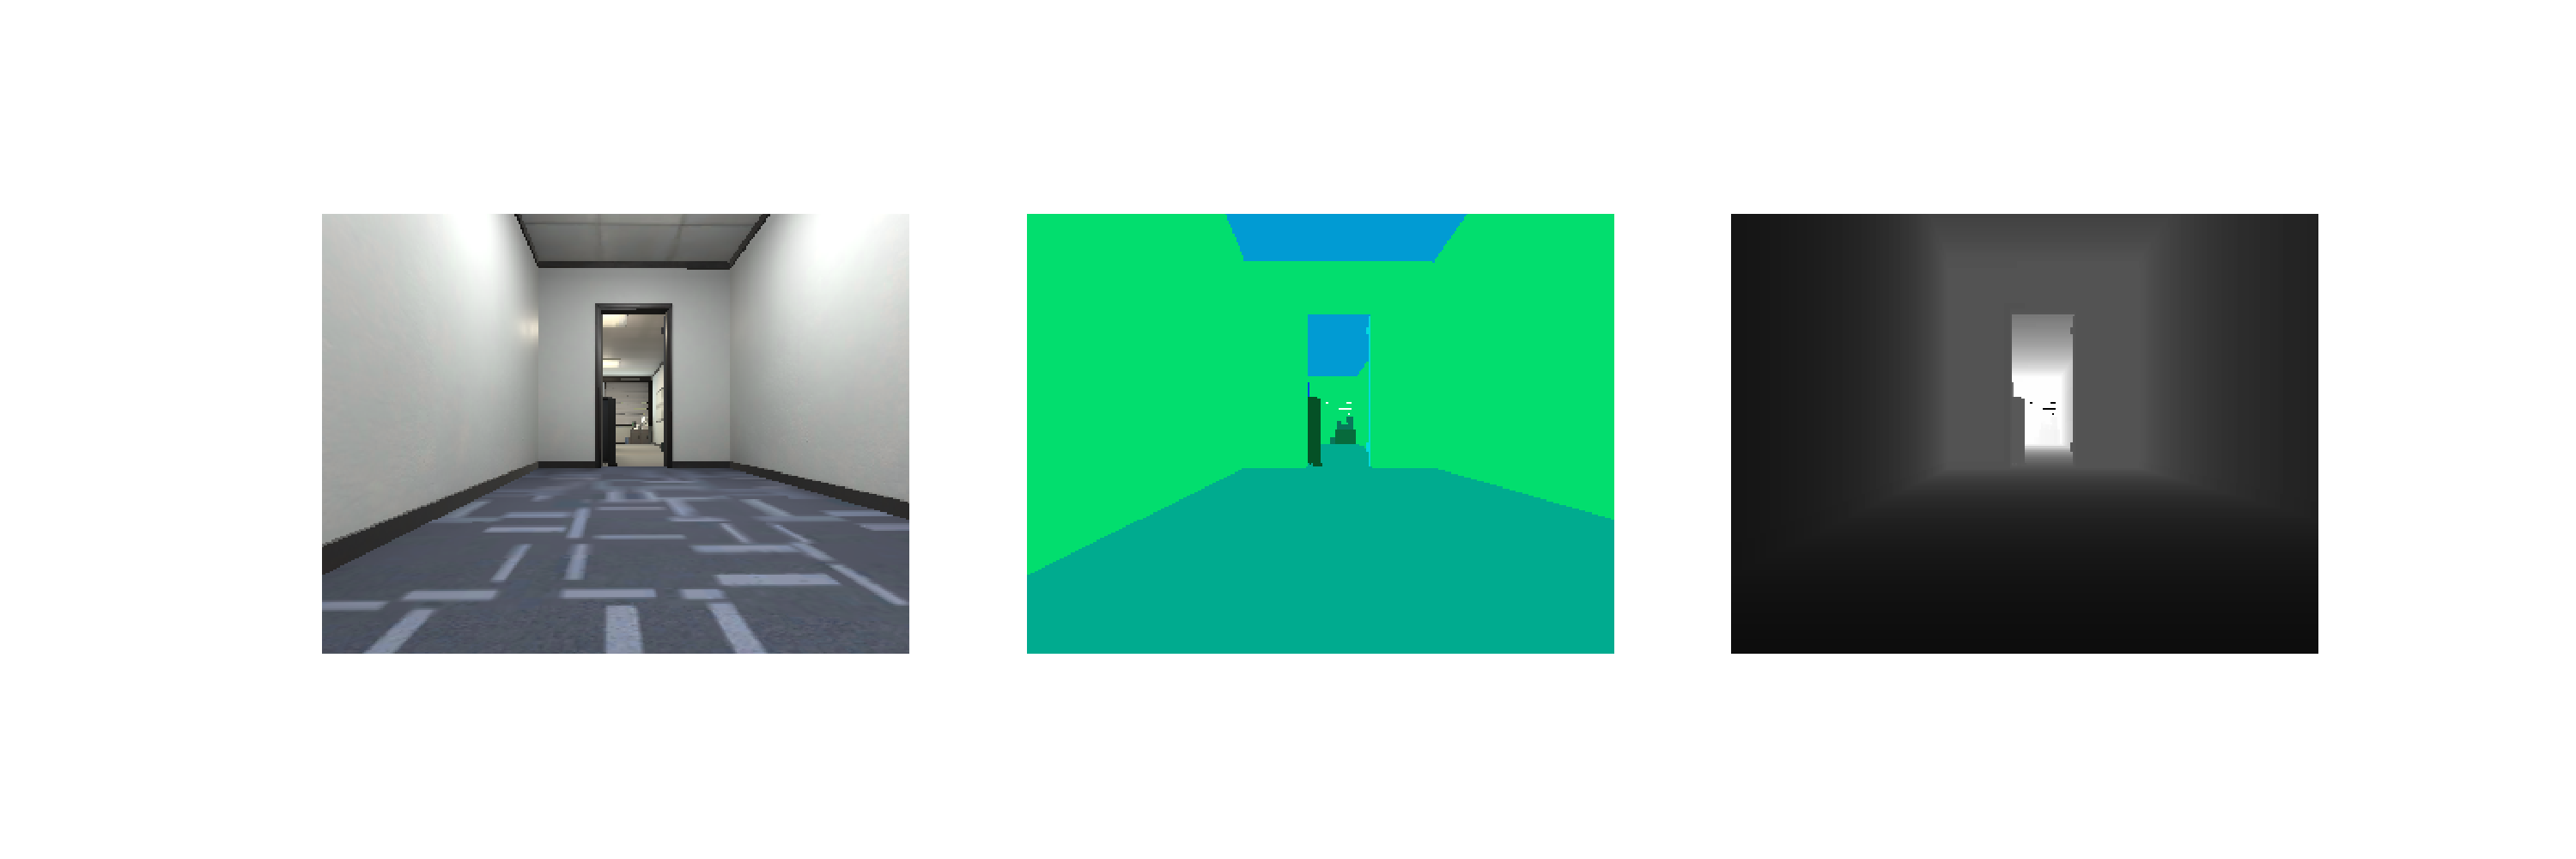

In [19]:
def plot(response, title=None):
    if len(response.images) == 0:
        return
    figsize = (len(response.images)*5, 5)
    fig, axs = plt.subplots(1, len(response.images), figsize=figsize)
    if len(response.images) > 1:
        for ax, img in zip(axs, response.images):
            ax.axis('off');
            ax.imshow(img, cmap='gray');
    else:
        axs.axis('off');
        axs.imshow(response.images[0], cmap='gray');
        axs.set_title(title)
cameras=[
    (Camera.RGB_LEFT, Compression.OFF, Channels.THREE),
    (Camera.SEGMENTATION, Compression.OFF, Channels.THREE),
    (Camera.DEPTH, Compression.OFF, Channels.THREE),
]
response = comm.request(DataRequest(metadata=False, cameras=cameras))
if response is not None:
    plot(response)

<IPython.core.display.Javascript object>


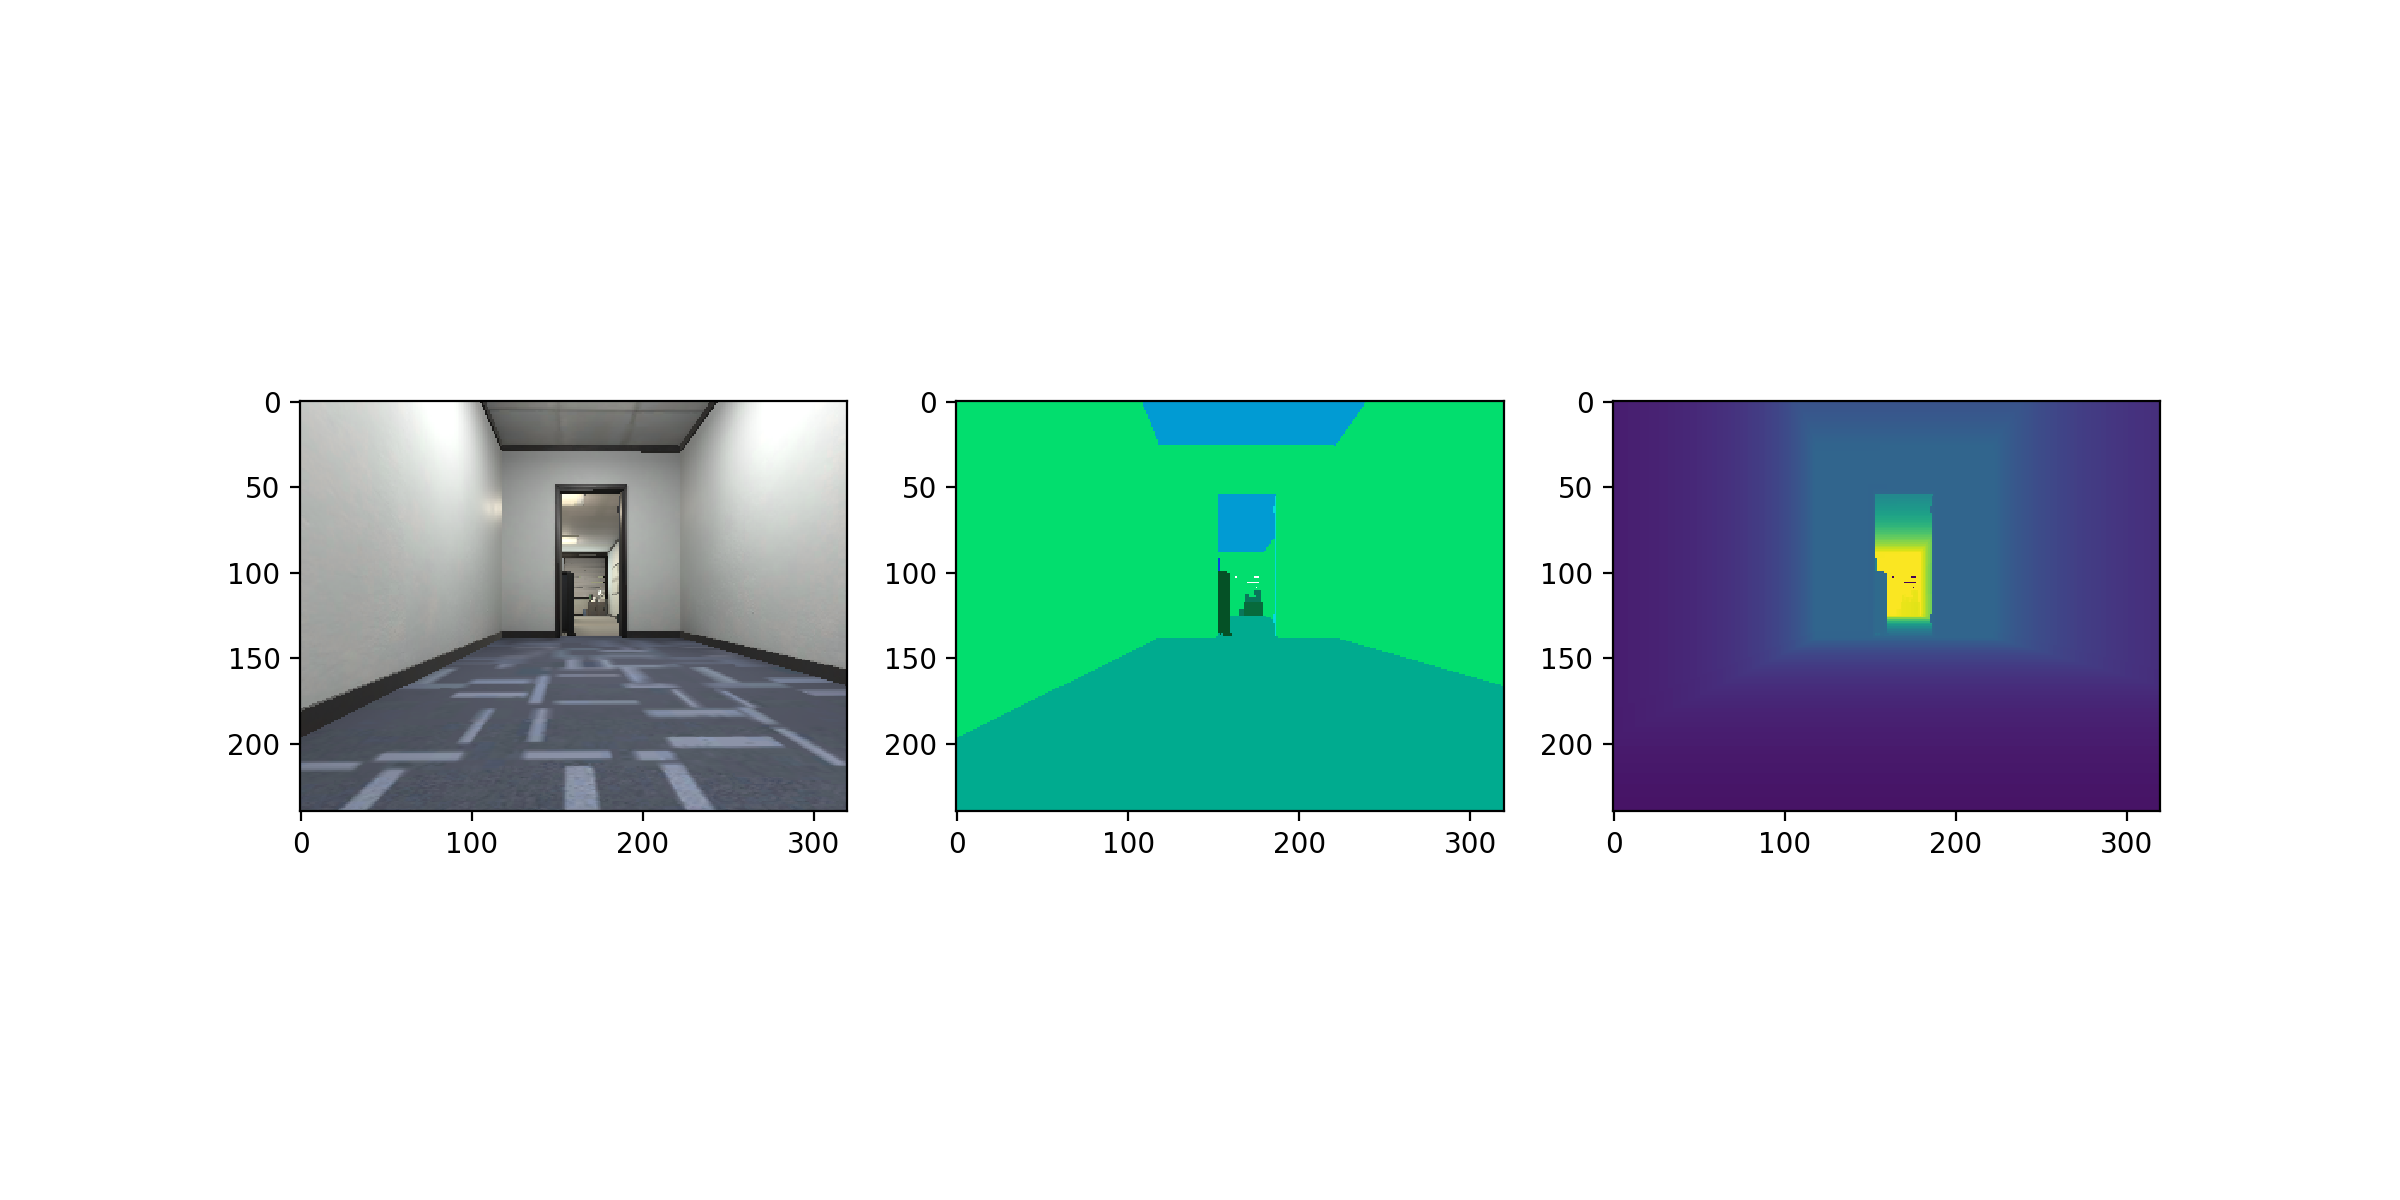

In [38]:
fig, ax = plt.subplots(1,3, figsize=(12, 6))
rgb, seg, depth = response.images
ax[0].imshow(rgb)
ax[1].imshow(seg)
ax[2].imshow(depth)

In [43]:
k_meter_to_millimeter = 1000
max_depth = 50
color_img = o3d.geometry.Image(rgb)
depth_img = o3d.geometry.Image((k_meter_to_millimeter * max_depth * depth).astype('float32'))
def extract_segment_class(segmentation_np):
    # Output from the segmentation has the following RGB channel values: [#SegmentationClass, #Rvalue, #Bvalue]
    # We extract the R channel for the segmentation class.
    seg, _, _ = np.split(segmentation_np, 3, axis=2)
    return np.copy(np.squeeze(seg))
# Convert to single channel np, force-copy for consecutive buffer, and convert to open3d image type.
segmentation_img = o3d.geometry.Image(extract_segment_class(seg))
rgbdseg = o3d.geometry.RGBDSegImage.create_from_color_depth_segmentation(color_img, depth_img,
                                                                         segmentation_img, depth_trunc=10.0,
                                                                         convert_rgb_to_intensity=False)

In [ ]:
o3d.visualization.draw_geometries([rgbdseg])